# Exploring Simple Network Architectures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt
import random

import numpy as np
import tensorflow as tf
import keras
from keras import layers

from aegomoku.game_data import read_training_data
import keras.initializers.initializers_v2 as initializers

In [3]:
BOARD_SIZE=15
filename = "rawdata.pickle"
examples = read_training_data(filename, BOARD_SIZE)
len(examples), len(examples[0]), examples[0][0].shape, np.array(examples[0][1]).shape

(20320, 3, (17, 17, 3), (225,))

In [4]:
inputs = keras.Input(shape=(17, 17, 3), name="inputs")

In [5]:
def xp(n, filters, kernel):
    return layers.Conv2D(
        name=f"expand_{n}_{kernel}x{kernel}",
        filters=filters, kernel_size=kernel,
        kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
        bias_initializer=tf.constant_initializer(0.),
        activation=tf.nn.softplus,
        padding='same')

In [6]:
def ct(n, filters, kernel):
    return layers.Conv2D(
        name=f"contract_{n}_{kernel}x{kernel}",
        filters=filters, kernel_size=kernel,
        kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
        bias_initializer=tf.constant_initializer(0.),
        activation=tf.nn.softplus,
        padding='same')

In [7]:
policy_aggregate = layers.Conv2D(
    name="policy_aggregator",
    filters=1, kernel_size=1,
    kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
    bias_initializer=tf.constant_initializer(0.),
    activation=tf.nn.relu,
    padding='same')

In [8]:
peel = layers.Conv2D(
    name="border_off",
    filters=1, kernel_size=(3, 3),
    kernel_initializer=tf.constant_initializer([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]),
    bias_initializer=tf.constant_initializer(0.),
    padding='valid',
    trainable=False)

In [9]:
x = xp(1, 1024, 11)(inputs)
c = ct(1, 4, 5)(x)

for i in range(2, 21):
    x = layers.concatenate([inputs, c], axis=-1)
    x = xp(i, 32, 5)(x)
    x = ct(i, 4, 3)(x)
    c = layers.Add(name=f"skip_{i}")([x, c])

x = policy_aggregate(c)
y = peel(x)
flatten = layers.Flatten()(y)
softmax = layers.Softmax()(flatten)
model = keras.Model(inputs=inputs, outputs=softmax)
model.compile()

2022-08-11 21:33:09.359282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 21:33:09.359970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 21:33:09.365327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 21:33:09.366022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 21:33:09.366924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 17, 17, 3)]  0           []                               
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 17, 17, 1024  372736      ['inputs[0][0]']                 
                                )                                                                 
                                                                                                  
 contract_1_5x5 (Conv2D)        (None, 17, 17, 4)    102404      ['expand_1_11x11[0][0]']         
                                                                                                  
 concatenate (Concatenate)      (None, 17, 17, 7)    0           ['inputs[0][0]',             

In [11]:
n = random.randint(0, 100)
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p = model(sample)
print((np.squeeze(p)*999).astype(np.uint8))

2022-08-11 21:33:12.587991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-11 21:33:12.780000: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


[  0   1   4   2   0   0   0   0   0   0   0   0   0   0   0   0  34  89
  60  14   2   3   2   4   5   7   9  24  13   0   0   1  66 202  22   5
   4   5   4   5  10  14  91 119  22   0   0   0   5   0   0   0   0   0
   1   1   3  10  21   5   0   0   0   1   0   0   0   0   0   0   0   0
   2   8   5   0   0   0   0   0   0   0   0   0   0   0   0   1   4   3
   0   0   0   0   0   0   0   0   0   0   0   0   0   2   1   0   0   0
   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   1   1   0
   0   0   0   1   1   0   0   0   0   0   0   1   5   9   2   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   1   0   0   0   0]


In [12]:
policy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [13]:
def create_dataset(data, batch_size=1024):
    subset = data
    x_train = np.asarray([t[0] for t in subset], dtype=float)
    pi_train = np.asarray([t[1] for t in subset])
    v_train = np.asarray([t[2] for t in subset])
    x_train_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
    pi_train_ds = tf.data.Dataset.from_tensor_slices(pi_train).batch(batch_size)
    v_train_ds = tf.data.Dataset.from_tensor_slices(v_train).batch(batch_size)
    all_train_ds = tf.data.Dataset.zip((x_train_ds, pi_train_ds, v_train_ds))
    all_train_ds = all_train_ds.shuffle(buffer_size=batch_size)
    return all_train_ds

In [14]:
metric = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

def train(train_examples, epochs_per_train=100, report_every=100):
    current_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)

    all_train_ds = create_dataset(train_examples)

    for epoch in range(epochs_per_train):
        for x_train, pi_train, _ in all_train_ds:
            train_step(x_train, pi_train)
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', metric.result(), step=epoch)

        if epoch % report_every == 1:
            print(f'Epoch: {epoch}, Training: {metric.result()}')

    print(f'Epochs: {epochs_per_train}, Loss: {metric.result()}')

    metric.reset_states()

@tf.function
def train_step(x, pi_y):
    with tf.GradientTape() as tape:
        probs = model(x, training=True)
        total_loss = policy_loss(pi_y, probs)

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    metric(total_loss)

In [15]:
N = 20000
train(examples[:N], epochs_per_train=200, report_every=10)

Epoch: 1, Training: 4.752285957336426
Epoch: 11, Training: 2.9848434925079346
Epoch: 21, Training: 2.1564090251922607
Epoch: 31, Training: 1.7780996561050415
Epoch: 41, Training: 1.5628230571746826
Epoch: 51, Training: 1.4222646951675415
Epoch: 61, Training: 1.3231887817382812
Epoch: 71, Training: 1.2489423751831055
Epoch: 81, Training: 1.1903598308563232
Epoch: 91, Training: 1.1424106359481812
Epoch: 101, Training: 1.1020166873931885
Epoch: 111, Training: 1.0669102668762207
Epoch: 121, Training: 1.0358970165252686
Epoch: 131, Training: 1.0086268186569214
Epoch: 141, Training: 0.9843030571937561
Epoch: 151, Training: 0.9624715447425842
Epoch: 161, Training: 0.9430054426193237
Epoch: 171, Training: 0.925442099571228
Epoch: 181, Training: 0.90947425365448
Epoch: 191, Training: 0.8950939774513245
Epochs: 200, Loss: 0.884390115737915


n=20095
Next to play: WHITE
Value from WHITE's point of view: -0.4677038941076586
Next to play: WHITE
Value from WHITE's point of view: 0.0


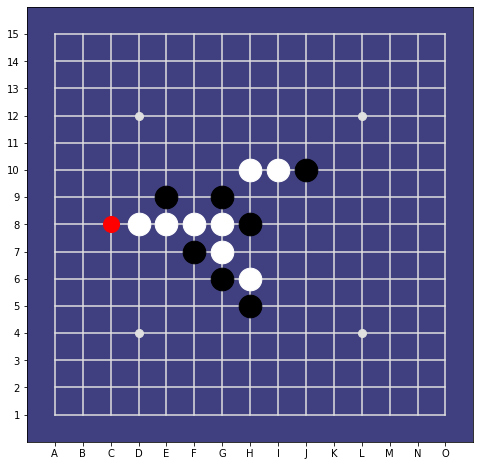

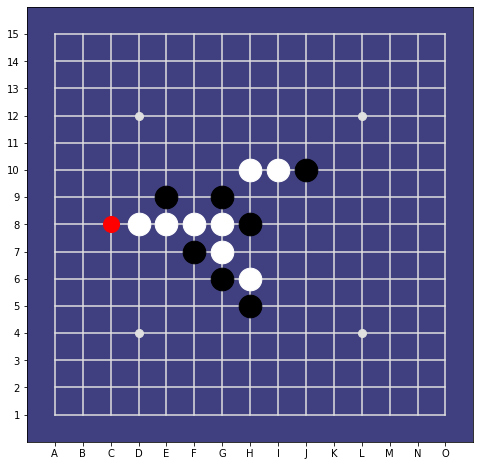

In [32]:
from aegomoku.utils import analyse_example

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p_ = model(sample)
s, p, _ = examples[n]
example = (s, list(p_.numpy()), 0.0)
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
analyse_example(BOARD_SIZE, example)